# Imports & Paths

In [1]:
from PIL import Image
from google.colab import userdata
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
try:
    from torchinfo import summary as info
except:
    !pip install torchinfo
    from torchinfo import summary as info

import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn

import json
import os
import torch

# Set the multiprocessing start method to 'spawn' for CUDA compatibility
# This should be done at the very beginning of your script, before any multiprocessing is started.
import torch.multiprocessing as mp
if __name__ == '__main__':
    try:
        mp.set_start_method('spawn', force=True) # Added force=True to override if already set
    except RuntimeError:
        # This happens if the start method is already set, which is fine.
        pass


from IPython.core.magic import register_cell_magic
@register_cell_magic
def skip(line, cell):
    print(line)
    return

In [2]:
project_path = userdata.get('PATH_PROJECT')
dataset_path = os.path.join(project_path, 'dataset')

train_path = os.path.join(dataset_path, 'train_metadata.json')
test_path = os.path.join(dataset_path, 'test_metadata.json')

import sys
src_path = os.path.join(project_path, 'src')
if src_path not in sys.path:
    sys.path.append(src_path)

## My Modules

In [3]:
import PairedImageDataset
import models

from importlib import reload
reload(PairedImageDataset)
reload(models);

# The Data & The Dataset Class

## Score Distribution
the variables `train_score_distribution` and `test_score_distribution` are used for stratified sampling.

In [4]:
with open(train_path) as train, open(test_path) as test:
    train_samples = json.load(train)
    test_samples = json.load(test)

# Get the scores for the training and testing sets
train_scores = [sample['score'] for sample in train_samples]
test_scores = [sample['score'] for sample in test_samples]

# Calculate the distribution of scores
train_score_distribution = pd.Series(train_scores).value_counts().sort_index()
test_score_distribution = pd.Series(test_scores).value_counts().sort_index()

# Display the distributions
print("Train set score distribution:")
display(train_score_distribution)

print("\nTest set score distribution:")
display(test_score_distribution)

Train set score distribution:


,count
0.0,1594
0.5,497
1.0,867



Test set score distribution:


,count
0.0,389
0.5,127
1.0,224


## Train set Mean & STD

In [5]:
%%skip Mean: tensor([0.5201, 0.4945, 0.4692]) Std: tensor([0.2581, 0.2339, 0.2377])

from PairedImageDataset import PairedImageDataset
import torch
from tqdm import tqdm

temp_dataset = PairedImageDataset(root_dir=dataset_path, metadata_json_path=train_path, preload=False, device='cpu')
# Create a dataloader for calculating mean and std
temp_dataloader = DataLoader(temp_dataset, batch_size=64, shuffle=False, num_workers=2)

n_pixels = 0
sum_ = torch.zeros(3)
sum_sq = torch.zeros(3)

for img_clean, img_other, _ in tqdm(temp_dataloader, desc="Calculating Mean and STD..."):
    # [2B, C, H, W]
    images = torch.cat((img_clean, img_other), dim=0)
    sum_ += images.sum(dim=[0, 2, 3])
    sum_sq += (images ** 2).sum(dim=[0, 2, 3])

# Compute mean and std
n_pixels = len(temp_dataset) * 2 * 20 * 20 # len(temp_dataset) pairs, each 20x20
mean = sum_ / n_pixels
std = torch.sqrt(sum_sq / n_pixels - mean ** 2)

print("\nMean:", mean)
print("Std:", std)


Mean: tensor([0.5201, 0.4945, 0.4692]) Std: tensor([0.2581, 0.2339, 0.2377])


In [6]:
TRAIN_MEANS = torch.tensor([0.5201, 0.4945, 0.4692])
TRAIN_STDS = torch.tensor([0.2581, 0.2339, 0.2377])

## Dataset & Dataloader

### w/o Albumentations

In [ ]:
# %%skip

from PairedImageDataset import PairedImageDataset

# <<--- Define the device: GPU if available, CPU otherwise --->>
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=TRAIN_MEANS, std=TRAIN_STDS),
])

# <<--- Create dataset instances --->>
train_dataset = PairedImageDataset(root_dir=dataset_path, metadata_json_path=train_path,
                                   preload=True, device=device, transform=transform
                                   )
test_dataset = PairedImageDataset(root_dir=dataset_path, metadata_json_path=test_path,
                                  preload=True, device=device, transform=transform
                                  )


### w/ Albumentations

In [7]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

train_transform = A.Compose([
    # Random flips
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),

    A.Normalize(mean=TRAIN_MEANS, std=TRAIN_STDS),
    ToTensorV2(),
],
    # tells Albumentations you’ll pass in a second image
    additional_targets={
        "image_other": "image"
    }
)

test_transform = A.Compose([
    A.Normalize(mean=TRAIN_MEANS, std=TRAIN_STDS),
    ToTensorV2(),
],
    additional_targets={
        "image_other": "image"
    }
)


In [8]:
from PairedImageDataset import PairedImageDataset_mk2

# <<--- Define the device: GPU if available, CPU otherwise --->>
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# <<--- Create dataset instances --->>
train_dataset = PairedImageDataset_mk2(root_dir=dataset_path, metadata_json_path=train_path,
                                   preload=False, device=device, transform=train_transform
                                   )
test_dataset = PairedImageDataset_mk2(root_dir=dataset_path, metadata_json_path=test_path,
                                  preload=False, device=device, transform=test_transform
                                  )


### Stratified Sampling Dataloader

Defines `train_class_weights`

In [9]:
from torch.utils.data import WeightedRandomSampler

score_to_label = {0: 0, 0.5: 1, 1: 2}

train_class_counts = train_score_distribution.values
train_class_weights = 1. / torch.tensor(train_class_counts, dtype=torch.float)
train_targets = [score_to_label[sample[2]] for sample in train_dataset.samples]
sample_weights = train_class_weights[train_targets]

sampler = WeightedRandomSampler(weights=sample_weights,
                                num_samples=len(sample_weights),
                                replacement=True)

In [10]:
# Create dataloader instances
batch_size = 32
is_pin_memory = 'mk2' in type(train_dataset).__name__
train_dataloader = DataLoader(train_dataset, batch_size=batch_size,
                              drop_last=True, num_workers=2,
                              sampler=sampler, pin_memory=is_pin_memory)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size,
                             shuffle=False, drop_last=False, num_workers=2,
                             pin_memory=is_pin_memory)

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of testing samples: {len(test_dataset)}")
print(f"Batch size: {batch_size}")

Number of training samples: 2958
Number of testing samples: 740
Batch size: 32


### Checking

In [ ]:
%%skip

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import DataLoader

# Use your existing train_dataset and sampler
exam_loader = DataLoader(
    train_dataset,
    batch_size=1,
    num_workers=2,
    sampler=sampler,
)

batch_img1, batch_img2, batch_label = next(iter(exam_loader))

# <<--- Check batch label distribution --->>

# Print the labels in this batch
print("Labels in this batch:", np.unique(batch_label.tolist()))

# Optional: count how many times each class appears in this batch
from collections import Counter
counts = Counter(batch_label.tolist())
print("Class counts in this batch:", counts)

# <<--- Visualize augmented images --->>

# Remove batch dimension (from 1, C, H, W -> C, H, W)
img1 = batch_img1[0]
img2 = batch_img2[0]
label = batch_label[0].item()

# Convert to HWC for plotting
def tensor_to_np(img_tensor):
    return img_tensor.permute(1, 2, 0).numpy()

img1_np = tensor_to_np(img1.cpu())
img2_np = tensor_to_np(img2.cpu())

# Plot the two images side by side
fig, axes = plt.subplots(1, 2, figsize=(6,3))
axes[0].imshow(img1_np.astype(np.uint8))
axes[0].set_title(f'Image 1 - Label: {label}')
axes[0].axis('off')

axes[1].imshow(img2_np.astype(np.uint8))
axes[1].set_title(f'Image 2 - Label: {label}')
axes[1].axis('off')

plt.tight_layout()
plt.show()


# Model & Training

## Pre Train

### Weighted SmoothL1 Loss and NoopLR Scheduler

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class WeightedSmoothL1Loss(nn.Module):
    def __init__(self, class_weights, beta=1.0, reduction='mean', factor=1.0):
        super().__init__()
        self.class_weights = (class_weights * factor).to(device)
        self.beta = beta
        self.reduction = reduction

    def forward(self, input, target):
        # compute SmoothL1 elementwise
        diff = torch.abs(input - target)
        loss = torch.where(diff < self.beta,
                           0.5 * diff ** 2 / self.beta,
                           diff - 0.5 * self.beta)

        # get weights based on class label
        score_to_label = {0: 0, 0.5: 1, 1: 2}
        labels = torch.tensor([score_to_label[s.item()] for s in target], device=device)

        weights = self.class_weights[labels.long()]
        loss = loss * weights

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss


In [ ]:
class NoopLR:
    def __init__(self, optimizer):
        self.optimizer = optimizer

    def step(self):
        # Do nothing
        pass

    def get_last_lr(self):
        # Return current learning rates to match PyTorch's scheduler API
        return [group['lr'] for group in self.optimizer.param_groups]


### Model

In [ ]:
from models import ImageComparisonModel_mk6 as ImageComparisonModel

# Instantiate the model
model = ImageComparisonModel()
display(info(model, input_size=[(1, 3, 20, 20), (1, 3, 20, 20)], device='cpu'))

Layer (type:depth-idx)                   Output Shape              Param #
ImageComparisonModel_mk6                 [1]                       --
├─Sequential: 1-1                        [1, 48, 5, 5]             --
│    └─Conv2d: 2-1                       [1, 16, 20, 20]           880
│    └─BatchNorm2d: 2-2                  [1, 16, 20, 20]           32
│    └─ReLU: 2-3                         [1, 16, 20, 20]           --
│    └─Conv2d: 2-4                       [1, 16, 20, 20]           2,320
│    └─BatchNorm2d: 2-5                  [1, 16, 20, 20]           32
│    └─ReLU: 2-6                         [1, 16, 20, 20]           --
│    └─MaxPool2d: 2-7                    [1, 16, 10, 10]           --
│    └─Conv2d: 2-8                       [1, 24, 10, 10]           3,480
│    └─BatchNorm2d: 2-9                  [1, 24, 10, 10]           48
│    └─ReLU: 2-10                        [1, 24, 10, 10]           --
│    └─Conv2d: 2-11                      [1, 24, 10, 10]           5,208
│    

In [ ]:
train_class_weights * factor

tensor([0.4962, 1.5915, 0.9123])

In [ ]:
# ============== DEFINITIONS ==============

# Loss functions
factor = [
    1 / train_class_weights.mean(),
    1e3,
    ] [0]

criterions = {
    'SmoothL1Loss': nn.SmoothL1Loss(),
    'WeightedSmoothL1Loss': WeightedSmoothL1Loss(train_class_weights, factor=factor),
}

# Optimizers
optimizers = {
    'Adam': torch.optim.Adam(model.parameters(), lr=1e-4),
    'SGD': torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9),
}

# Learning rate scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR, CosineAnnealingLR

lr_schedulers = lambda sched, optimizer: {
    'NoopLR': NoopLR(optimizer),
    'ReduceLROnPlateau': ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5,
                                           threshold=1e-4, min_lr=1e-6),
    'StepLR': StepLR(optimizer, step_size=5, gamma=0.5),
    'CosineAnnealingLR': CosineAnnealingLR(optimizer, T_max=80, eta_min=1e-5),
} [sched]


# ============== INSTANTIATION ==============

criterion = criterions['WeightedSmoothL1Loss']

optimizer = optimizers['SGD']

scheduler = lr_schedulers('CosineAnnealingLR', optimizer)



# Define the device: GPU if available, CPU otherwise
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("Loss function:", criterion)
print("Optimizer:", optimizer)
print("Scheduler:", type(scheduler).__name__)
print("Device:", device)

## Training loop

### Loop

In [ ]:

# Training loop
num_epochs = 80
model.to(device)

# Lists to store losses and learning rates for plotting later
train_losses = []
test_losses = []
lrs = [] # List to store learning rates

try:
    for epoch in range(num_epochs):
        model.train()
        print(f"Start Epoch [{epoch+1}/{num_epochs}]")

        running_loss = 0.0
        # Iterate over the training data in batches
        for batch, (img_clean, img_other, scores) in enumerate(train_dataloader, start=1):
            print(f"\rbatch {batch}/{len(train_dataloader)}", end='') # Print how many batchs are done
            # If not preloaded - Move batch data to the device
            if not train_dataset.preload:
                img_clean = img_clean.to(device)
                img_other = img_other.to(device)
                scores = scores.to(device).float() # Ensure scores are float and have shape (batch_size, 1)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            # Model outputs are now regression scores: (batch_size, 1)
            outputs = model(img_clean, img_other)

            # Calculate the loss (MSELoss for regression)
            loss = criterion(outputs, scores)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * img_clean.size(0) # Accumulate loss, weighted by batch size

        print() # Newline after same-line batch number print
        # Calculate average epoch loss
        epoch_loss = running_loss / len(train_dataset)
        train_losses.append(epoch_loss) # Store training loss

        # Print training loss
        print(f"Average Training Loss: {epoch_loss:.4f}")



        # Evaluation on test data
        with torch.no_grad():
            model.eval()
            test_running_loss = 0.0
            for batch, (img_clean, img_other, scores) in enumerate(test_dataloader, start=1):
                print(f"\rbatch {batch}/{len(test_dataloader)}", end='') # Print how many batchs are done
                # If not preloaded - Move batch data to the device
                if not train_dataset.preload:
                    img_clean = img_clean.to(device)
                    img_other = img_other.to(device)
                    scores = scores.to(device).float() # Ensure scores are float and have shape (batch_size, 1)

                test_outputs = model(img_clean, img_other)

                test_running_loss += criterion(test_outputs, scores).item() * img_clean.size(0) # Accumulate loss

        print() # Newline after same-line batch number print
        # Calculate average test loss
        test_loss = test_running_loss / len(test_dataset)
        test_losses.append(test_loss) # Store test loss

        # Step the scheduler based on the test loss
        scheduler.step()

        # Record the learning rate at the end of the epoch
        lrs.append(optimizer.param_groups[0]['lr'])


        print(f"Test Loss: {test_loss:.4f}")
        print(f"End Epoch [{epoch+1}/{num_epochs}]")

except KeyboardInterrupt:
    print("\nKeyboardInterrupt detected. Exiting gracefully.")

print("Training finished!")

# Plotting the training and test losses and learning rate
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot losses on the first y-axis
ax1.plot(range(1, num_epochs + 1), train_losses, label='Training Loss', color='blue')
ax1.plot(range(1, num_epochs + 1), test_losses, label='Test Loss', color='red')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True)

# Create a second y-axis for the learning rate
ax2 = ax1.twinx()
ax2.plot(range(1, num_epochs + 1), lrs, label='Learning Rate', color='green', linestyle='--')
ax2.set_ylabel('Learning Rate', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Add legends
fig.tight_layout()  # Adjust layout to prevent labels overlapping
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.title('Training and Test Loss and Learning Rate per Epoch')
plt.show()

Start Epoch [1/80]
batch 92/92
Average Training Loss: 0.7294
batch 24/24
Test Loss: 0.1465
End Epoch [1/80]
Start Epoch [2/80]
batch 92/92
Average Training Loss: 0.1132
batch 24/24
Test Loss: 0.1412
End Epoch [2/80]
Start Epoch [3/80]
batch 92/92
Average Training Loss: 0.0881
batch 24/24
Test Loss: 0.0933
End Epoch [3/80]
Start Epoch [4/80]
batch 92/92
Average Training Loss: 0.0800
batch 24/24
Test Loss: 0.1868
End Epoch [4/80]
Start Epoch [5/80]
batch 92/92
Average Training Loss: 0.0803
batch 24/24
Test Loss: 0.0731
End Epoch [5/80]
Start Epoch [6/80]
batch 92/92
Average Training Loss: 0.0734
batch 24/24
Test Loss: 0.0911
End Epoch [6/80]
Start Epoch [7/80]
batch 92/92
Average Training Loss: 0.0710
batch 24/24
Test Loss: 0.1276
End Epoch [7/80]
Start Epoch [8/80]
batch 92/92
Average Training Loss: 0.0771
batch 24/24
Test Loss: 0.1085
End Epoch [8/80]
Start Epoch [9/80]
batch 92/92
Average Training Loss: 0.0707
batch 24/24
Test Loss: 0.0916
End Epoch [9/80]
Start Epoch [10/80]
batch 92

### Final Pass

In [ ]:
# Set the model to evaluation mode
model.eval()

# Define the device: GPU if available, CPU otherwise
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move the model to the device
model.to(device)

# Disable gradient calculation
with torch.no_grad():
    # --- Evaluate Loss on Training Set ---
    print("Calculating loss on training set...")
    train_running_loss = 0.0
    train_total_samples = 0

    for img_clean, img_other, scores in train_dataloader:
        # Move batch data to the device
        img_clean = img_clean.to(device)
        img_other = img_other.to(device)
        scores = scores.to(device).float()

        outputs = model(img_clean, img_other)
        # Clamp the outputs to the range [0, 1]
        # outputs = torch.clamp(outputs, 0, 1)

        loss = criterion(outputs, scores)
        train_running_loss += loss.item() * img_clean.size(0)
        train_total_samples += img_clean.size(0)

    train_avg_loss = train_running_loss / train_total_samples
    print(f"Average Training Loss: {train_avg_loss:.4f}")


    # --- Evaluate Loss on Test Set ---
    print("\nCalculating loss on test set...")
    test_running_loss = 0.0
    test_total_samples = 0

    for img_clean, img_other, scores in test_dataloader:
        # Move batch data to the device
        img_clean = img_clean.to(device)
        img_other = img_other.to(device)
        scores = scores.to(device).float()

        test_outputs = model(img_clean, img_other)
        # Clamp the outputs to the range [0, 1]
        # test_outputs = torch.clamp(test_outputs, 0, 1)

        test_running_loss += criterion(test_outputs, scores).item() * img_clean.size(0)
        test_total_samples += img_clean.size(0)

    test_avg_loss = test_running_loss / test_total_samples
    print(f"Average Test Loss: {test_avg_loss:.4f}")

## Save the model

In [ ]:
# %%skip Comment out skip to save the model

# Define the path to save the model
model_save_path = os.path.join(project_path, 'src/saves/image_comparison_model_mk6_7.pth')

# Save the model's state dictionary
torch.save(model.state_dict(), model_save_path)

print(f"Model saved to: {model_save_path}")

Model saved to: /content/drive/MyDrive/Colab Notebooks/Samsung/src/saves/image_comparison_model_mk6_7.pth


# Evaluation
Compute the confusion matrix for the test set predictions and true scores, using the bins [0-0.3, 0.3-0.6, 0.6-1] and the labels [RED, ORANGE, GREEN].

## Load The Model

In [24]:
from models import ImageComparisonModel_mk6 as ImageComparisonModel

# Load the trained model
model = ImageComparisonModel() # Instantiate the model first

model_save_path = os.path.join(project_path, 'src/saves/image_comparison_model_mk6_7.pth')
model.load_state_dict(torch.load(model_save_path, map_location='cuda'))

print(f"Model loaded successfully from: {model_save_path}")

Model loaded successfully from: /content/drive/MyDrive/Colab Notebooks/Samsung/src/saves/image_comparison_model_mk6_7.pth


## Run inference

Use the trained model to get predictions for all samples.


In [127]:
def evaluate(model, dataloader):
    '''
    Return (all_outputs, all_scores)
    '''
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    # Set the model to evaluation mode
    model.eval()
    model.to(device)

    from tqdm import tqdm
    # Disable gradient calculation

    with torch.no_grad():
        # Get predictions for the test set by iterating through the dataloader
        all_outputs = []
        all_scores = [] # Store true scores for evaluation

        for img_clean, img_other, scores in tqdm(dataloader):
            # Move batch data to the device (if not preloaded)
            img_clean = img_clean.to(device)
            img_other = img_other.to(device)
            scores = scores.to(device).float() # Ensure scores are float and have shape (batch_size, 1)

            outputs = model(img_clean, img_other)
            outputs = outputs.clamp(0, 1)

            all_outputs.append(outputs.cpu()) # Move to CPU for concatenation and later processing
            all_scores.append(scores.cpu()) # Move true scores to CPU

        # Concatenate all batch outputs and true scores
        all_outputs = torch.cat(all_outputs, dim=0)
        all_scores = torch.cat(all_scores, dim=0)
    print()

    return all_outputs, all_scores

In [28]:
from  albumentations import Normalize
from albumentations.pytorch import ToTensorV2

TRAIN_MEANS = torch.tensor([0.5201, 0.4945, 0.4692])
TRAIN_STDS = torch.tensor([0.2581, 0.2339, 0.2377])

eval_transform = A.Compose([
    Normalize(mean=TRAIN_MEANS, std=TRAIN_STDS),
    ToTensorV2(),
],
    additional_targets={
        "image_other": "image"
    }
)

batch_size = 32
eval_train_dataset = PairedImageDataset_mk2(root_dir=dataset_path, metadata_json_path=train_path,
                                  preload=False, device=device, transform=eval_transform
                                  )
eval_test_dataset = PairedImageDataset_mk2(root_dir=dataset_path, metadata_json_path=test_path,
                                  preload=False, device=device, transform=eval_transform
                                  )

eval_train_dataloader = DataLoader(eval_train_dataset, batch_size=batch_size, num_workers=2)
eval_test_dataloader = DataLoader(eval_test_dataset, batch_size=batch_size, num_workers=2)

In [128]:
eval_train_outputs, eval_train_scores = evaluate(model, eval_train_dataloader)

print("All outputs shape:", eval_train_outputs.shape)
print("All true scores shape:", eval_train_scores.shape)
print("Sample outputs (predicted scores):", eval_train_outputs[:5])
print("Sample true scores:", eval_train_scores[:5])


eval_test_outputs, eval_test_scores = evaluate(model, eval_test_dataloader)

print("All outputs shape:", eval_test_outputs.shape)
print("All true scores shape:", eval_test_scores.shape)
print("Sample outputs (predicted scores):", eval_test_outputs[:5])
print("Sample true scores:", eval_test_scores[:5])


100%|██████████| 93/93 [00:18<00:00,  5.03it/s]



All outputs shape: torch.Size([2958])
All true scores shape: torch.Size([2958])
Sample outputs (predicted scores): tensor([0.5569, 0.2067, 0.9750, 0.2531, 0.9240])
Sample true scores: tensor([1., 0., 1., 0., 1.])


100%|██████████| 24/24 [00:11<00:00,  2.04it/s]


All outputs shape: torch.Size([740])
All true scores shape: torch.Size([740])
Sample outputs (predicted scores): tensor([0.8693, 0.4949, 0.5138, 0.9647, 0.0403])
Sample true scores: tensor([0.5000, 0.0000, 0.5000, 1.0000, 0.0000])


## Find the Best Bin Values

Exploiting the fact predictions are finite:
You only need to check boundaries at the midpoints between sorted prediction values.
For example, if predictions are

[0.12, 0.20, 0.35, 0.40, ...]

then possible useful thresholds are

[
$\frac{0.12 + 0.20}{2}$,
$\frac{0.20 + 0.35}{2}$,
....
]





In [153]:
import numpy as np

def find_best_boundaries(preds, labels, label_map = {0:0, 0.5:1, 1:2}):
    """
    preds: 1D numpy array of predictions in [0,1]
    labels: 1D numpy array of true labels {0,0.5,1}
    label_map: dict for converting float prediction values to ints
    Returns: (best_b1, best_b2, best_acc)
    """

    labels_int = np.array([label_map[l] for l in labels])

    # Candidate thresholds
    sorted_preds = np.sort(preds)
    candidates = (sorted_preds[:-1] + sorted_preds[1:]) / 2.0
    candidates = np.unique(candidates)

    best_acc = -1
    best_b1, best_b2 = None, None

    for i, b1 in enumerate(candidates):
        for b2 in candidates[i+1:]:
            digitized = np.digitize(preds, bins=[b1, b2])  # gives 0,1,2
            acc = (digitized == labels_int).mean()

            if acc > best_acc:
                best_acc = acc
                best_b1, best_b2 = b1, b2

    return best_b1, best_b2, best_acc


# ============== USAGE ==============


preds = eval_train_outputs.numpy()
labels = eval_train_scores.numpy()

b1, b2, acc = find_best_boundaries(preds, labels)
print(f"Best boundaries: b1={b1:.3f}, b2={b2:.3f}, Accuracy={acc:.3f}")


Best boundaries: b1=0.402, b2=0.648, Accuracy=0.871


## Digitize predictions & true scores

Convert the continuous model outputs and the float testset labels into discrete labels.

e.g. bins `[0-0.3, 0.3-0.6, 0.6-1]`.


In [139]:
import numpy as np

# Define the upper bounds of the bins
# bins = [0.3, 0.6, 1.0]
bins = [b1, b2, 1.0]

# right=True -> the rightmost bin includes the edge value (1.0)
predicted_class_indices = np.digitize(eval_test_outputs.numpy().flatten(), bins, right=True)
true_class_indices = np.digitize(eval_test_scores.numpy().flatten(), bins, right=True)

## Compute the confusion matrix

In [149]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(true_class_indices, predicted_class_indices, labels=[0, 1, 2], normalize='true')
# From floats to precentages
conf_matrix *= 100

display(conf_matrix)

array([[88.43187661, 10.53984576,  1.02827763],
       [24.40944882, 51.96850394, 23.62204724],
       [ 0.89285714, 12.5       , 86.60714286]])

## Display the confusion matrix

Model Accuracy: 0.8162
Macro Precision: 0.7507, Macro Recall: 0.7567, Macro F1 Score: 0.7535

Per-Class Metrics:
     Red:   Precision=0.9125, Recall=0.8843, F1 Score=0.8982, Support=389
  Orange:   Precision=0.4889, Recall=0.5197, F1 Score=0.5038, Support=127
   Green:   Precision=0.8509, Recall=0.8661, F1 Score=0.8584, Support=224


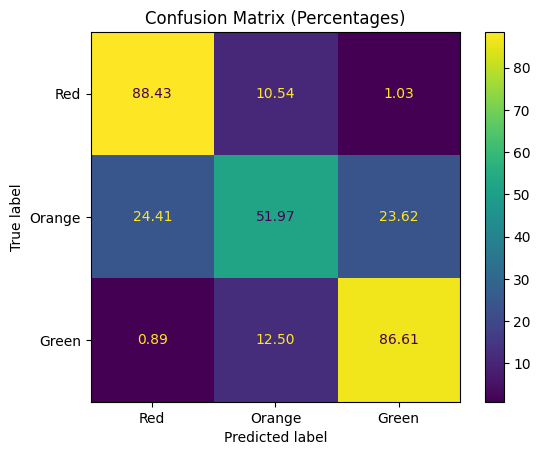

In [145]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np # Import numpy for digitize

# Calculate accuracy
accuracy = accuracy_score(true_class_indices, predicted_class_indices)

# Define labels for metrics and display
labels_names = ['Red', 'Orange', 'Green']
labels_indices = [0, 1, 2]

# Calculate precision, recall, and F1-score (macro)
# We need to specify the labels and zero_division to handle cases with no predictions
precision_macro, recall_macro, fscore_macro, _ = precision_recall_fscore_support(
    true_class_indices, predicted_class_indices, average='macro', labels=labels_indices, zero_division=0
)
# Also calculate per-class metrics for more detail
precision_per_class, recall_per_class, fscore_per_class, support_per_class = precision_recall_fscore_support(
    true_class_indices, predicted_class_indices, labels=labels_indices, zero_division=0
)


print(f"Model Accuracy: {accuracy:.4f}")
print(f"Macro Precision: {precision_macro:.4f}, Macro Recall: {recall_macro:.4f}, Macro F1 Score: {fscore_macro:.4f}")
print("\nPer-Class Metrics:")
for i, label_name in enumerate(labels_names):
    print(f"  {label_name.rjust(6, ' ')}:   Precision={precision_per_class[i]:.4f}, Recall={recall_per_class[i]:.4f}, F1 Score={fscore_per_class[i]:.4f}, Support={support_per_class[i]}")


# Create a display object for the confusion matrix
cmd = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=labels_names)

# Plot the confusion matrix with values formatted as percentages
fig, ax = plt.subplots()
cmd.plot(values_format=".2f", ax=ax)  # use ax to keep control

# Force all text to black
# for text in ax.texts:
#     text.set_color("black")

# Add a title to the plot
plt.title('Confusion Matrix (Percentages)')

# Display the plot
plt.show()


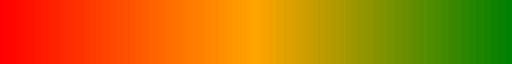

In [101]:
from matplotlib.colors import LinearSegmentedColormap

# Define colors and corresponding positions
colors = ["red", "orange", "green"]
positions = [0.0, 0.5, 1.0]

# Create colormap
mycmap = LinearSegmentedColormap.from_list("red_orange_green", list(zip(positions, colors)), N=256)
mycmap